# 마케팅 ROI 심층 분석 리포트

**기간**: 2024-10-01 ~ 2024-12-29 (90일)  
**채널**: Google Ads, Facebook Ads, Naver Ads  
**목표**: 채널별 ROAS 분석 → 예산 최적화 제안 → 비즈니스 인사이트 도출

---

## 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
import os

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (OS별 자동 감지)
import platform
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (12, 6)

# 채널별 고정 색상
CHANNEL_COLORS = {
    'Google Ads': '#4285F4',
    'Facebook Ads': '#1877F2',
    'Naver Ads': '#03C75A'
}

# 차트 저장 디렉토리
CHARTS_DIR = 'charts'
os.makedirs(CHARTS_DIR, exist_ok=True)

def save_chart(fig, filename):
    """차트를 PNG로 저장"""
    path = os.path.join(CHARTS_DIR, filename)
    fig.savefig(path, bbox_inches='tight', facecolor='white')
    print(f'저장: {path}')

print('환경 설정 완료')
print(f'OS: {system}')
print(f'pandas: {pd.__version__}')

환경 설정 완료
OS: Windows
pandas: 2.3.3


## 2. 데이터 로딩 및 품질 점검

In [2]:
# 데이터 로딩
df = pd.read_csv('data/marketing_raw_data.csv', parse_dates=['date'])

print(f'데이터 shape: {df.shape}')
print(f'기간: {df["date"].min().strftime("%Y-%m-%d")} ~ {df["date"].max().strftime("%Y-%m-%d")}')
print(f'채널: {df["channel"].unique().tolist()}')
print(f'캠페인 수: {df["campaign"].nunique()}')
print()
df.head(10)

데이터 shape: (810, 8)
기간: 2024-10-01 ~ 2024-12-29
채널: ['Google Ads', 'Facebook Ads', 'Naver Ads']
캠페인 수: 9



,date,channel,campaign,cost,impressions,clicks,conversions,revenue
0,2024-10-01,Google Ads,Google_Brand,182.78,13773,979,51,638.65
1,2024-10-01,Google Ads,Google_Generic,386.84,28735,908,16,781.60
2,2024-10-01,Google Ads,Google_Retargeting,118.34,9091,589,18,331.45
3,2024-10-01,Facebook Ads,FB_Interest,163.96,17340,677,17,253.09
4,2024-10-01,Facebook Ads,FB_Lookalike,210.30,17315,569,19,432.84
5,2024-10-01,Facebook Ads,FB_Retargeting,99.76,8993,442,19,218.96
6,2024-10-01,Naver Ads,Naver_Brand,147.61,10524,752,51,514.86
7,2024-10-01,Naver Ads,Naver_Shopping,272.16,26479,1171,36,627.70
8,2024-10-01,Naver Ads,Naver_Retargeting,99.73,11342,780,44,368.11
9,2024-10-02,Google Ads,Google_Brand,188.70,20664,1602,84,700.75


In [3]:
# 데이터 타입 확인
print('=== 데이터 타입 ===')
print(df.dtypes)
print()

# 결측치 확인
print('=== 결측치 ===')
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else '결측치 없음')
print()

# 기술 통계
print('=== 기술 통계 ===')
df.describe().round(2)

=== 데이터 타입 ===
date           datetime64[ns]
channel                object
campaign               object
cost                  float64
impressions             int64
clicks                  int64
conversions             int64
revenue               float64
dtype: object

=== 결측치 ===
결측치 없음

=== 기술 통계 ===


,date,cost,impressions,clicks,conversions,revenue
count,810,810.00,810.00,810.00,810.00,810.00
mean,2024-11-14 12:00:00,214.16,19271.49,906.60,38.89,574.01
min,2024-10-01 00:00:00,51.68,3874.00,242.00,3.00,90.18
25%,2024-10-23 00:00:00,127.02,11142.25,621.00,22.00,353.89
50%,2024-11-14 12:00:00,184.19,16005.00,819.00,31.50,485.93
75%,2024-12-07 00:00:00,273.80,25364.75,1121.50,47.00,691.67
max,2024-12-29 00:00:00,674.03,62627.00,2881.00,230.00,3124.70
std,NaN,109.75,10927.36,399.33,25.39,336.74


In [4]:
# 파생 변수 생성
df['roas'] = df['revenue'] / df['cost']
df['ctr'] = df['clicks'] / df['impressions']
df['cvr'] = np.where(df['clicks'] > 0, df['conversions'] / df['clicks'], 0)
df['cpc'] = df['cost'] / df['clicks']
df['weekday'] = df['date'].dt.dayofweek  # 0=월, 6=일
df['weekday_name'] = df['date'].dt.day_name()
df['is_weekend'] = df['weekday'].isin([5, 6])
df['week'] = df['date'].dt.isocalendar().week.astype(int)

print(f'파생 변수 추가 완료. 총 컬럼: {len(df.columns)}')
print(f'추가된 컬럼: roas, ctr, cvr, cpc, weekday, weekday_name, is_weekend, week')

파생 변수 추가 완료. 총 컬럼: 16
추가된 컬럼: roas, ctr, cvr, cpc, weekday, weekday_name, is_weekend, week


## 3. 탐색적 데이터 분석 (EDA)

채널별 성과, ROAS 추이, 캠페인별 성과를 시각적으로 탐색합니다.

저장: charts\01_channel_cost_revenue.png


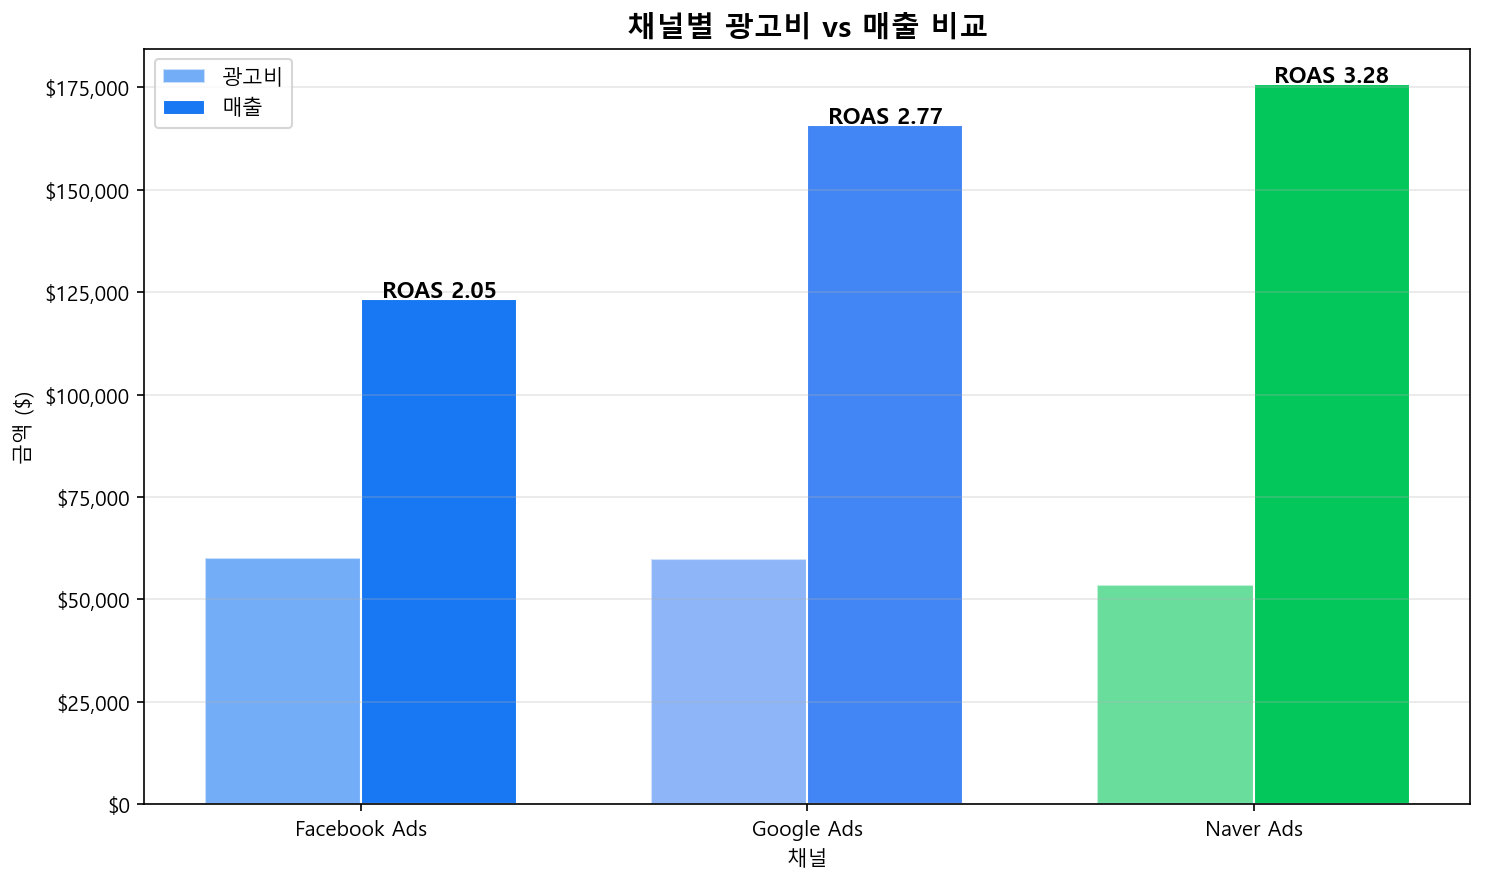

In [5]:
# 차트 1: 채널별 광고비-매출 비교 (Grouped Bar)
channel_summary = df.groupby('channel').agg(
    total_cost=('cost', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_conversions=('conversions', 'sum')
).reset_index()
channel_summary['roas'] = channel_summary['total_revenue'] / channel_summary['total_cost']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(channel_summary))
width = 0.35

bars1 = ax.bar(x - width/2, channel_summary['total_cost'], width,
               label='광고비', color=[CHANNEL_COLORS[c] for c in channel_summary['channel']],
               alpha=0.6, edgecolor='white')
bars2 = ax.bar(x + width/2, channel_summary['total_revenue'], width,
               label='매출', color=[CHANNEL_COLORS[c] for c in channel_summary['channel']],
               alpha=1.0, edgecolor='white')

# ROAS 텍스트 표시
for i, row in channel_summary.iterrows():
    ax.text(i + width/2, row['total_revenue'] + 500,
            f'ROAS {row["roas"]:.2f}', ha='center', fontweight='bold', fontsize=11)

ax.set_xlabel('채널')
ax.set_ylabel('금액 ($)')
ax.set_title('채널별 광고비 vs 매출 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(channel_summary['channel'])
ax.legend()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '01_channel_cost_revenue.png')
plt.show()

저장: charts\02_daily_roas_trend.png


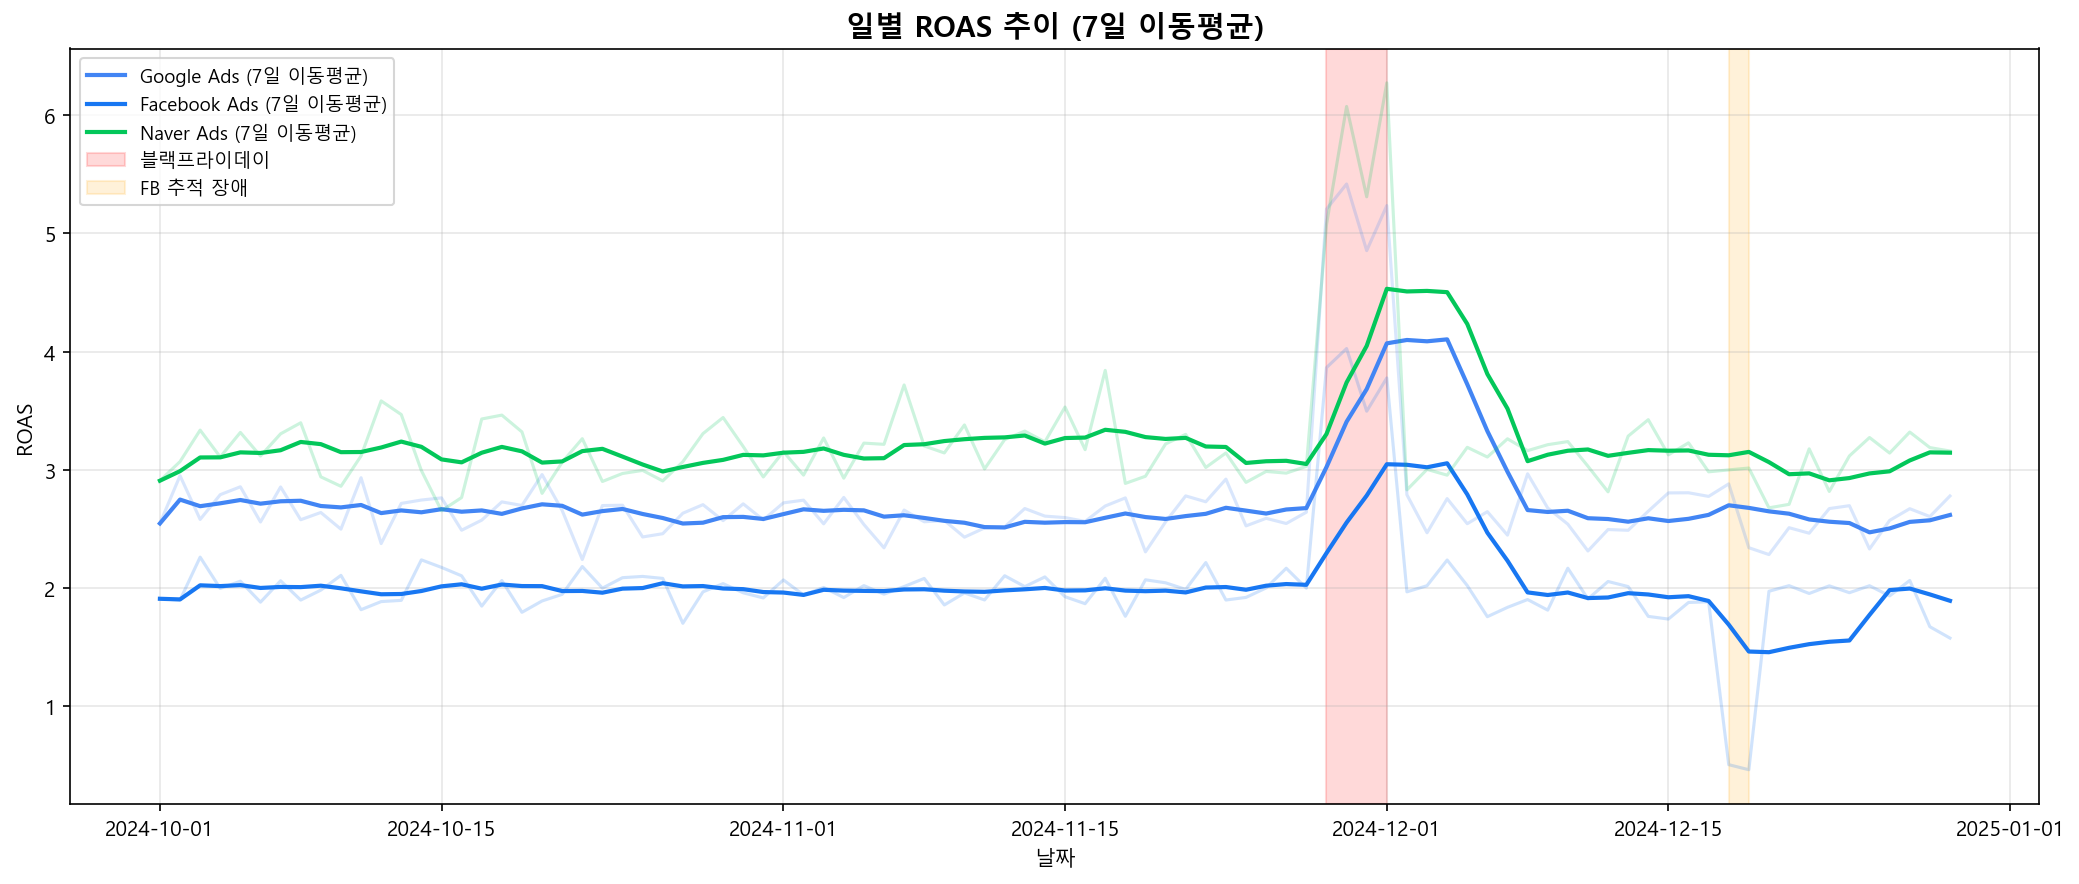

In [6]:
# 차트 2: 일별 ROAS 추이 (7일 이동평균)
fig, ax = plt.subplots(figsize=(14, 6))

for channel in df['channel'].unique():
    ch_daily = df[df['channel'] == channel].groupby('date').agg(
        cost=('cost', 'sum'), revenue=('revenue', 'sum')
    ).reset_index()
    ch_daily['roas'] = ch_daily['revenue'] / ch_daily['cost']
    ch_daily['roas_ma7'] = ch_daily['roas'].rolling(window=7, min_periods=1).mean()

    ax.plot(ch_daily['date'], ch_daily['roas'], alpha=0.2,
            color=CHANNEL_COLORS[channel])
    ax.plot(ch_daily['date'], ch_daily['roas_ma7'],
            color=CHANNEL_COLORS[channel], label=f'{channel} (7일 이동평균)',
            linewidth=2)

# 블랙프라이데이 표시
ax.axvspan(pd.Timestamp('2024-11-28'), pd.Timestamp('2024-12-01'),
           alpha=0.15, color='red', label='블랙프라이데이')

# FB 추적 장애 표시
ax.axvspan(pd.Timestamp('2024-12-18'), pd.Timestamp('2024-12-19'),
           alpha=0.15, color='orange', label='FB 추적 장애')

ax.set_xlabel('날짜')
ax.set_ylabel('ROAS')
ax.set_title('일별 ROAS 추이 (7일 이동평균)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
save_chart(fig, '02_daily_roas_trend.png')
plt.show()

저장: charts\03_campaign_matrix.png


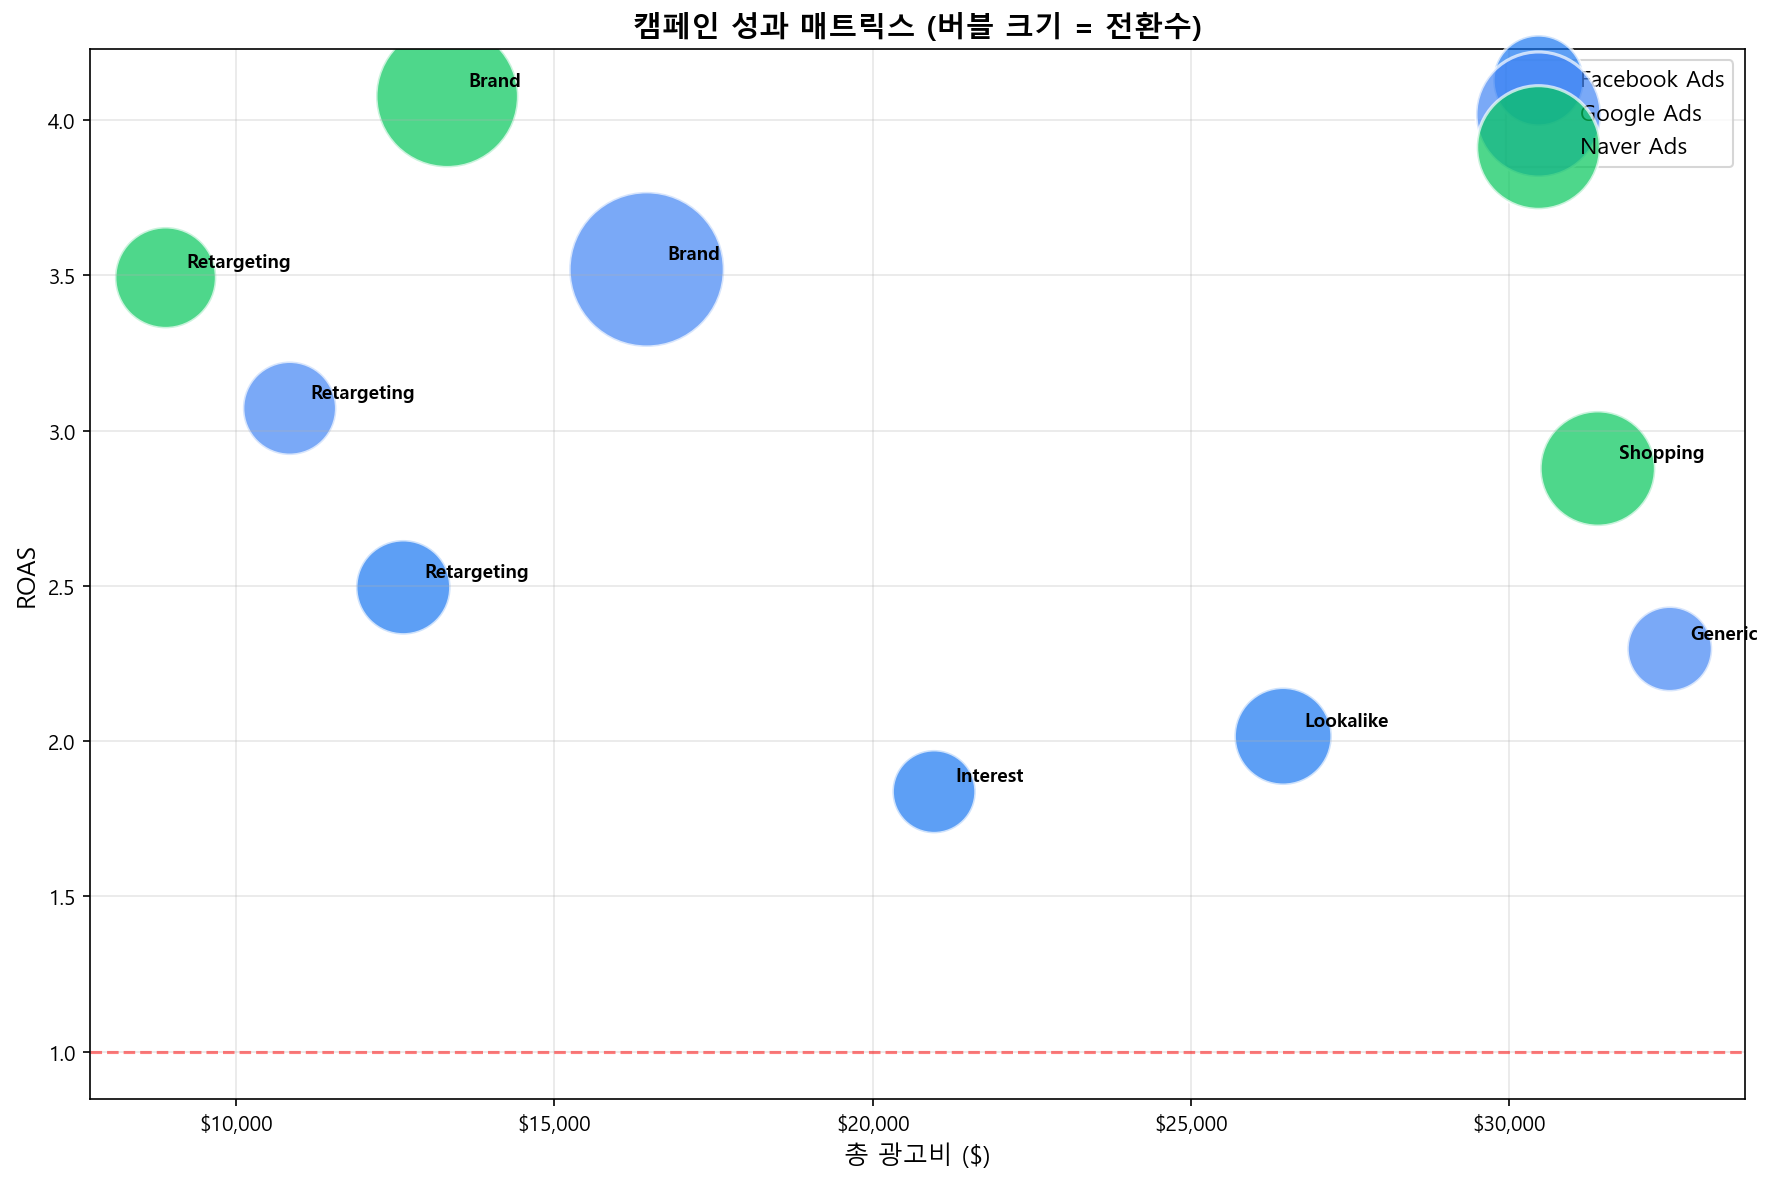


=== 캠페인별 성과 요약 ===
          채널                캠페인   총 광고비    총 매출 ROAS  총 전환수
Facebook Ads        FB_Interest $20,966 $38,520 1.84   2007
Facebook Ads       FB_Lookalike $26,448 $53,310 2.02   2740
Facebook Ads     FB_Retargeting $12,630 $31,515 2.50   2585
  Google Ads       Google_Brand $16,453 $57,895 3.52   6930
  Google Ads     Google_Generic $32,520 $74,692 2.30   2083
  Google Ads Google_Retargeting $10,845 $33,314 3.07   2526
   Naver Ads        Naver_Brand $13,320 $54,296 4.08   5843
   Naver Ads  Naver_Retargeting  $8,897 $31,072 3.49   2965
   Naver Ads     Naver_Shopping $31,390 $90,332 2.88   3822


In [7]:
# 차트 3: 캠페인 성과 매트릭스 (Bubble Chart)
camp_summary = df.groupby(['channel', 'campaign']).agg(
    total_cost=('cost', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_conversions=('conversions', 'sum')
).reset_index()
camp_summary['roas'] = camp_summary['total_revenue'] / camp_summary['total_cost']

fig, ax = plt.subplots(figsize=(12, 8))

for channel in camp_summary['channel'].unique():
    mask = camp_summary['channel'] == channel
    data = camp_summary[mask]
    scatter = ax.scatter(
        data['total_cost'], data['roas'],
        s=data['total_conversions'] * 0.8,
        c=CHANNEL_COLORS[channel],
        alpha=0.7, edgecolors='white', linewidth=1.5,
        label=channel
    )
    for _, row in data.iterrows():
        camp_short = row['campaign'].split('_')[-1]
        ax.annotate(camp_short,
                    (row['total_cost'], row['roas']),
                    textcoords='offset points', xytext=(10, 5),
                    fontsize=9, fontweight='bold')

ax.set_xlabel('총 광고비 ($)', fontsize=12)
ax.set_ylabel('ROAS', fontsize=12)
ax.set_title('캠페인 성과 매트릭스 (버블 크기 = 전환수)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.grid(alpha=0.3)

# ROAS=1 기준선
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='손익분기 (ROAS=1)')

plt.tight_layout()
save_chart(fig, '03_campaign_matrix.png')
plt.show()

# 캠페인별 상세 수치
print('\n=== 캠페인별 성과 요약 ===')
camp_summary_display = camp_summary[['channel', 'campaign', 'total_cost', 'total_revenue', 'roas', 'total_conversions']].copy()
camp_summary_display.columns = ['채널', '캠페인', '총 광고비', '총 매출', 'ROAS', '총 전환수']
camp_summary_display['총 광고비'] = camp_summary_display['총 광고비'].apply(lambda x: f'${x:,.0f}')
camp_summary_display['총 매출'] = camp_summary_display['총 매출'].apply(lambda x: f'${x:,.0f}')
camp_summary_display['ROAS'] = camp_summary_display['ROAS'].apply(lambda x: f'{x:.2f}')
print(camp_summary_display.to_string(index=False))

## 4. 심층 분석

요일별 채널 성과 패턴과 광고비-매출 체감수익 구조를 분석합니다.

저장: charts\04_weekday_heatmap.png


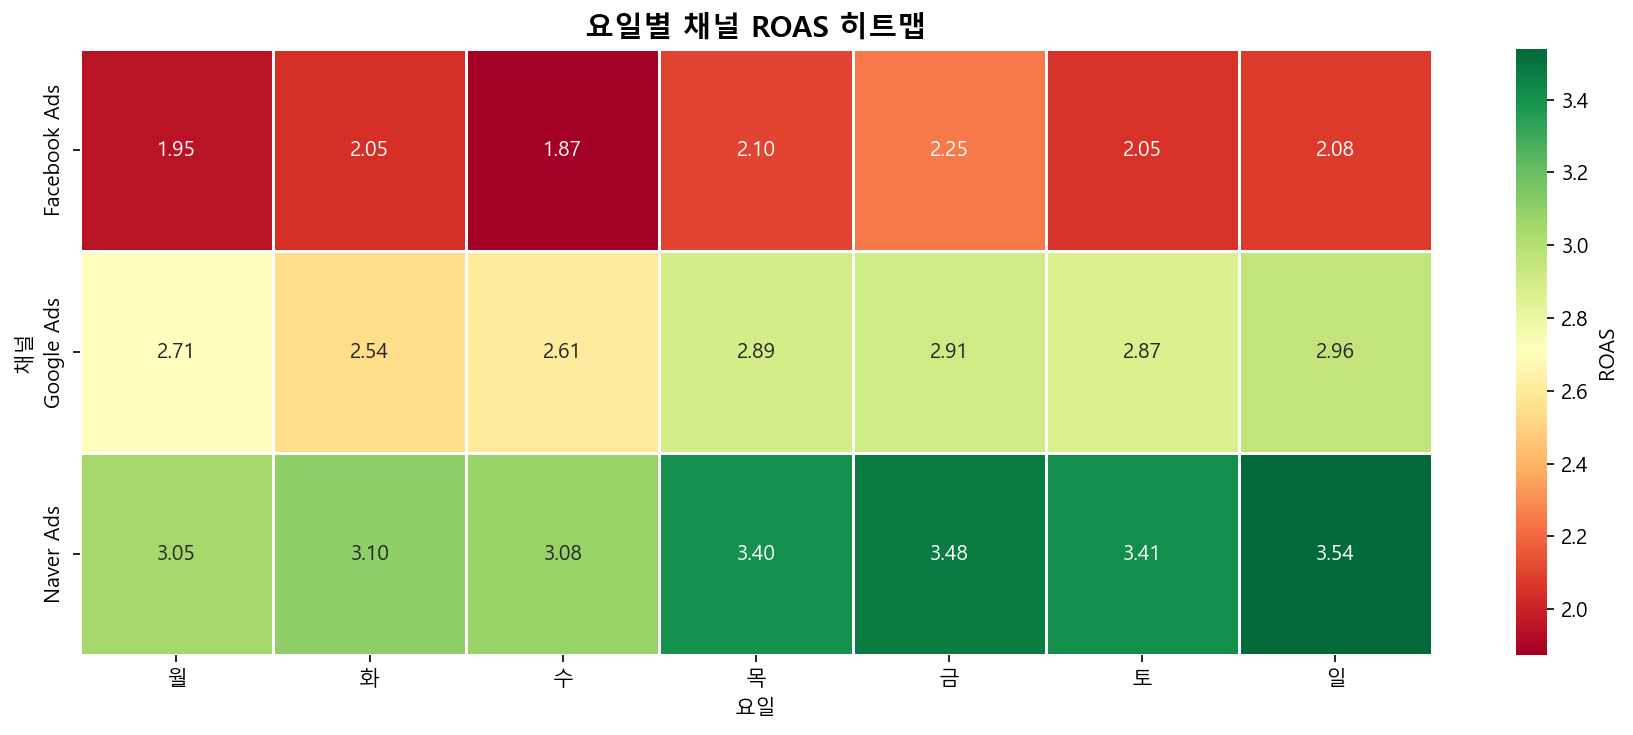


인사이트: Google Ads와 Naver Ads는 주중 성과가 높고, Facebook Ads는 주말에 강세를 보입니다.


In [8]:
# 차트 4: 요일별 채널 성과 히트맵
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_kr = ['월', '화', '수', '목', '금', '토', '일']

pivot_roas = df.groupby(['channel', 'weekday_name']).apply(
    lambda x: x['revenue'].sum() / x['cost'].sum()
).reset_index()
pivot_roas.columns = ['channel', 'weekday_name', 'roas']
pivot_table = pivot_roas.pivot(index='channel', columns='weekday_name', values='roas')
pivot_table = pivot_table[weekday_order]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn',
            center=pivot_table.values.mean(),
            xticklabels=weekday_kr,
            linewidths=0.5, ax=ax,
            cbar_kws={'label': 'ROAS'})

ax.set_title('요일별 채널 ROAS 히트맵', fontsize=14, fontweight='bold')
ax.set_xlabel('요일')
ax.set_ylabel('채널')

plt.tight_layout()
save_chart(fig, '04_weekday_heatmap.png')
plt.show()

print('\n인사이트: Google Ads와 Naver Ads는 주중 성과가 높고, Facebook Ads는 주말에 강세를 보입니다.')

저장: charts\05_diminishing_returns.png


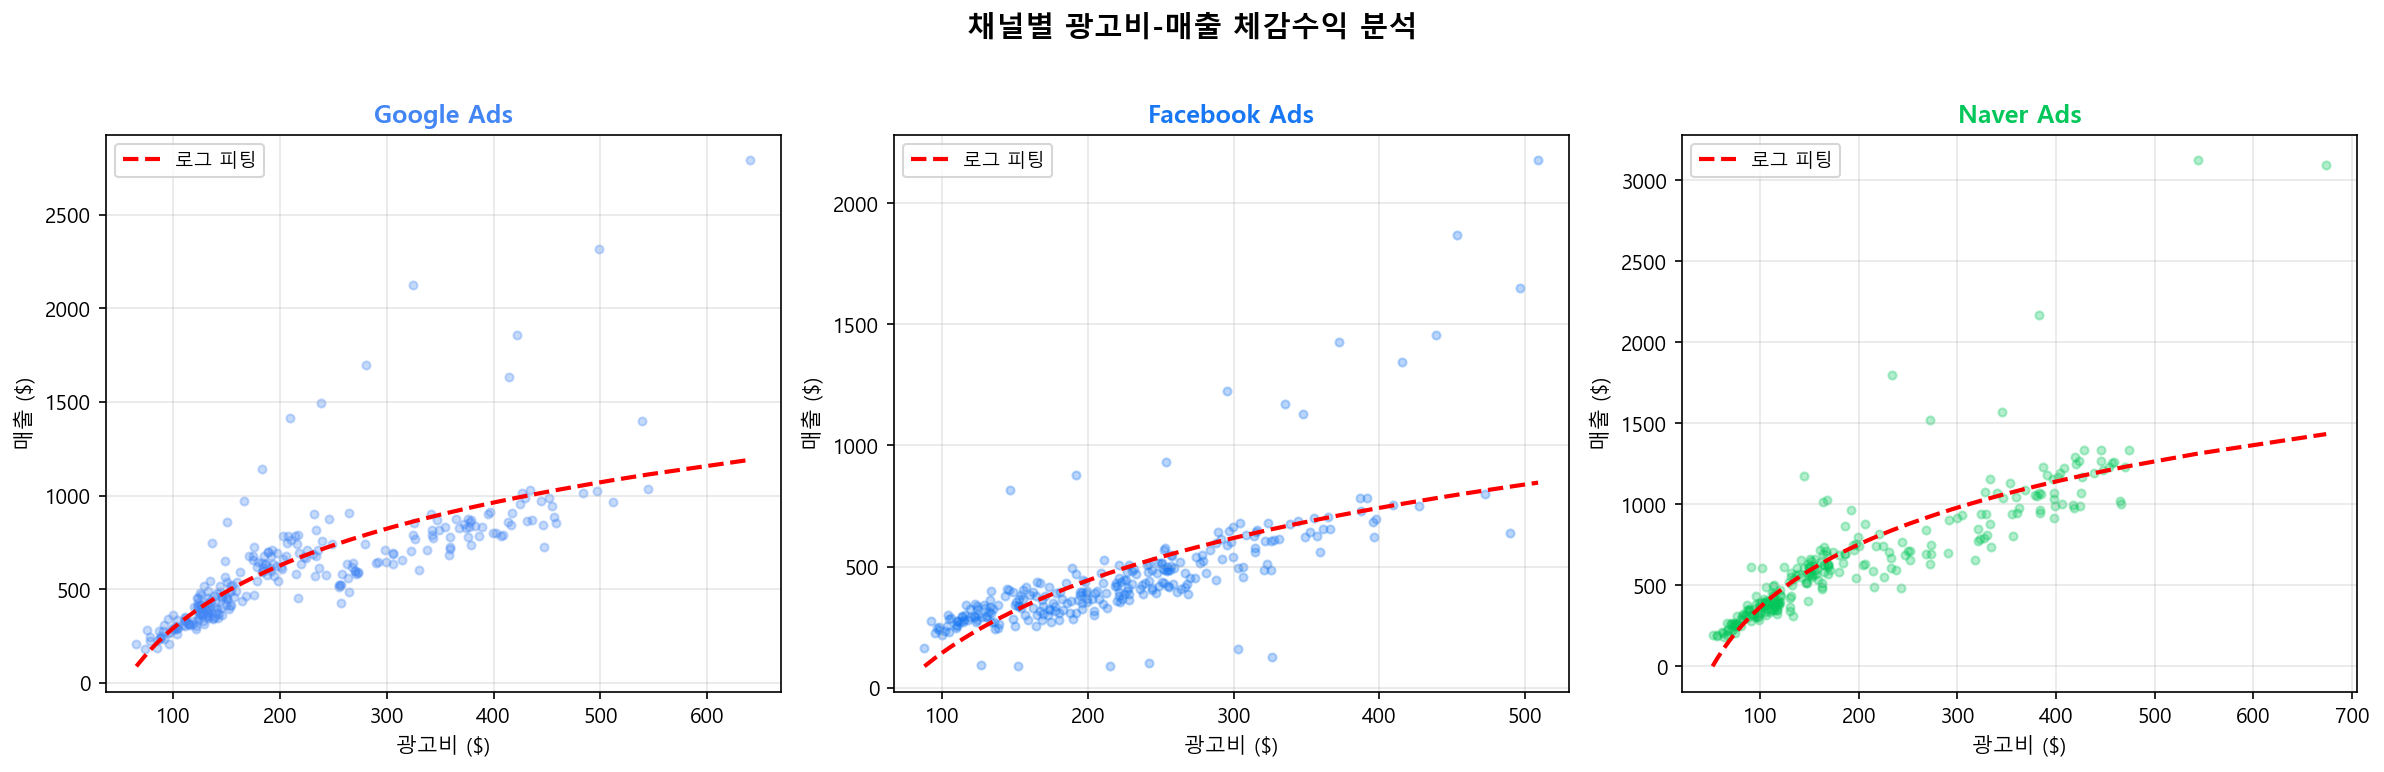

인사이트: 광고비 증가에 따라 매출 증가율이 둔화되는 체감수익 패턴이 확인됩니다.
이는 예산 배분 최적화의 핵심 근거가 됩니다.


In [9]:
# 차트 5: 광고비-매출 체감수익 (Scatter + Log Curve)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, channel in enumerate(df['channel'].unique()):
    ch_data = df[df['channel'] == channel].copy()
    ax = axes[idx]

    ax.scatter(ch_data['cost'], ch_data['revenue'],
              alpha=0.3, s=15, color=CHANNEL_COLORS[channel])

    # 로그 곡선 피팅
    x_sorted = np.sort(ch_data['cost'].values)
    log_x = np.log(x_sorted + 1)
    coeffs = np.polyfit(np.log(ch_data['cost'].values + 1), ch_data['revenue'].values, 1)
    y_fit = coeffs[0] * np.log(x_sorted + 1) + coeffs[1]

    ax.plot(x_sorted, y_fit, color='red', linewidth=2, linestyle='--',
            label='로그 피팅')

    ax.set_title(channel, fontsize=12, fontweight='bold',
                 color=CHANNEL_COLORS[channel])
    ax.set_xlabel('광고비 ($)')
    ax.set_ylabel('매출 ($)')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle('채널별 광고비-매출 체감수익 분석', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_chart(fig, '05_diminishing_returns.png')
plt.show()

print('인사이트: 광고비 증가에 따라 매출 증가율이 둔화되는 체감수익 패턴이 확인됩니다.')
print('이는 예산 배분 최적화의 핵심 근거가 됩니다.')

## 5. 통계 검정

관찰된 패턴이 통계적으로 유의한지 검증합니다.

In [10]:
# 5-1. 주중 vs 주말 ROAS 차이 (t-test)
print('=== 주중 vs 주말 ROAS 차이 검정 (독립표본 t-test) ===\n')

for channel in df['channel'].unique():
    ch_data = df[df['channel'] == channel]
    weekday_roas = ch_data[~ch_data['is_weekend']]['roas']
    weekend_roas = ch_data[ch_data['is_weekend']]['roas']

    t_stat, p_value = stats.ttest_ind(weekday_roas, weekend_roas)
    sig = '유의' if p_value < 0.05 else '비유의'

    print(f'{channel}:')
    print(f'  주중 ROAS 평균: {weekday_roas.mean():.3f} | 주말 ROAS 평균: {weekend_roas.mean():.3f}')
    print(f'  t-통계량: {t_stat:.3f} | p-value: {p_value:.4f} → {sig} (α=0.05)')
    print()

# 5-2. 채널 간 ROAS 차이 (One-Way ANOVA)
print('=== 채널 간 ROAS 차이 검정 (One-Way ANOVA) ===\n')

google_roas = df[df['channel'] == 'Google Ads']['roas']
fb_roas = df[df['channel'] == 'Facebook Ads']['roas']
naver_roas = df[df['channel'] == 'Naver Ads']['roas']

f_stat, p_value = stats.f_oneway(google_roas, fb_roas, naver_roas)
print(f'F-통계량: {f_stat:.3f}')
print(f'p-value: {p_value:.2e}')
print(f'결론: 채널 간 ROAS 차이가 통계적으로 {"매우 유의" if p_value < 0.001 else "유의" if p_value < 0.05 else "비유의"}합니다.')

=== 주중 vs 주말 ROAS 차이 검정 (독립표본 t-test) ===

Google Ads:
  주중 ROAS 평균: 2.887 | 주말 ROAS 평균: 3.005
  t-통계량: -1.085 | p-value: 0.2788 → 비유의 (α=0.05)

Facebook Ads:
  주중 ROAS 평균: 2.087 | 주말 ROAS 평균: 2.074
  t-통계량: 0.166 | p-value: 0.8679 → 비유의 (α=0.05)

Naver Ads:
  주중 ROAS 평균: 3.395 | 주말 ROAS 평균: 3.603
  t-통계량: -1.888 | p-value: 0.0601 → 비유의 (α=0.05)

=== 채널 간 ROAS 차이 검정 (One-Way ANOVA) ===

F-통계량: 229.530
p-value: 1.21e-79
결론: 채널 간 ROAS 차이가 통계적으로 매우 유의합니다.


저장: charts\06_statistical_tests.png


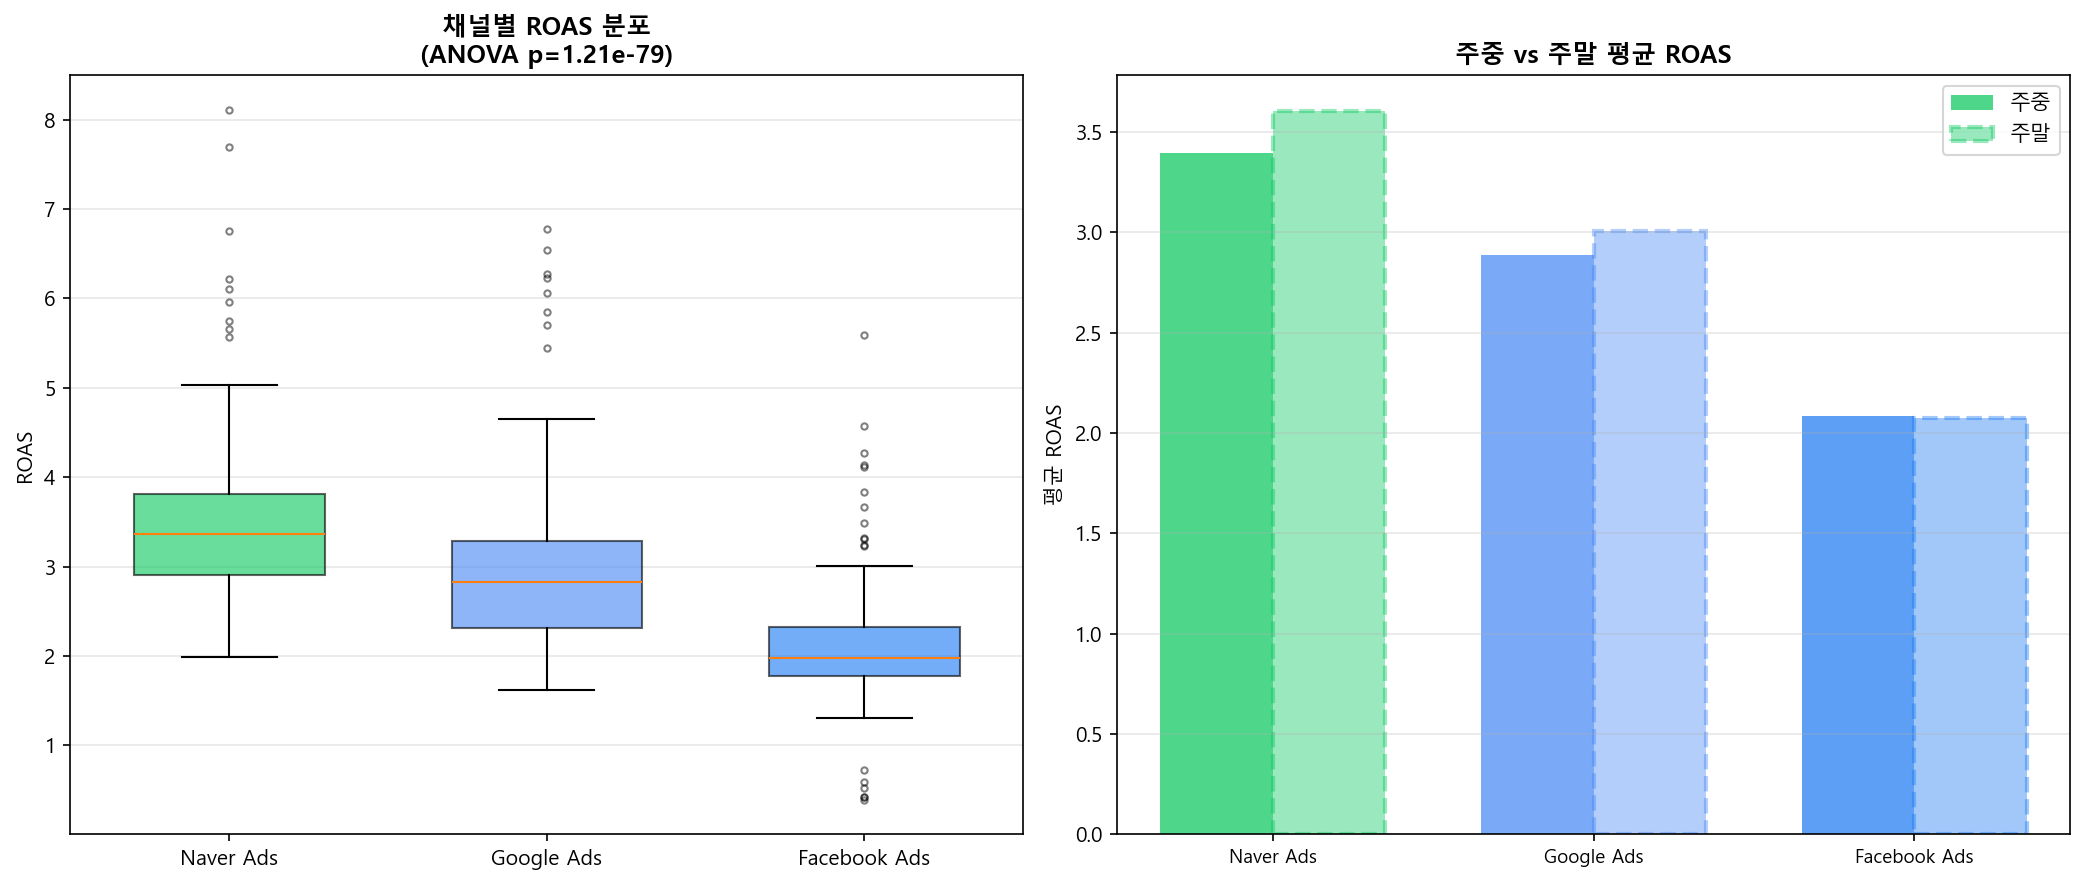

In [11]:
# 차트 6: 통계 검정 결과 시각화 (Box Plot + p-value)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 6a: 채널별 ROAS 분포 (Box Plot)
ax1 = axes[0]
channel_order = ['Naver Ads', 'Google Ads', 'Facebook Ads']
box_colors = [CHANNEL_COLORS[c] for c in channel_order]

bp = ax1.boxplot(
    [df[df['channel'] == c]['roas'] for c in channel_order],
    labels=channel_order,
    patch_artist=True,
    widths=0.6,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, alpha=0.5)
)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax1.set_title(f'채널별 ROAS 분포\n(ANOVA p={p_value:.2e})',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('ROAS')
ax1.grid(axis='y', alpha=0.3)

# 6b: 주중/주말 ROAS 비교
ax2 = axes[1]
weekday_data = []
weekend_data = []
labels = []
colors = []

for channel in channel_order:
    ch_data = df[df['channel'] == channel]
    wd = ch_data[~ch_data['is_weekend']]['roas'].mean()
    we = ch_data[ch_data['is_weekend']]['roas'].mean()
    weekday_data.append(wd)
    weekend_data.append(we)
    labels.append(channel)
    colors.append(CHANNEL_COLORS[channel])

x = np.arange(len(labels))
width = 0.35
ax2.bar(x - width/2, weekday_data, width, label='주중', color=colors, alpha=0.7)
ax2.bar(x + width/2, weekend_data, width, label='주말', color=colors, alpha=0.4,
        edgecolor=colors, linewidth=2, linestyle='--')

ax2.set_title('주중 vs 주말 평균 ROAS', fontsize=12, fontweight='bold')
ax2.set_ylabel('평균 ROAS')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '06_statistical_tests.png')
plt.show()

## 6. 회귀 분석

광고비와 매출 관계를 모델링하여 최적의 예측 모델을 선정합니다.

저장: charts\07_regression_comparison.png


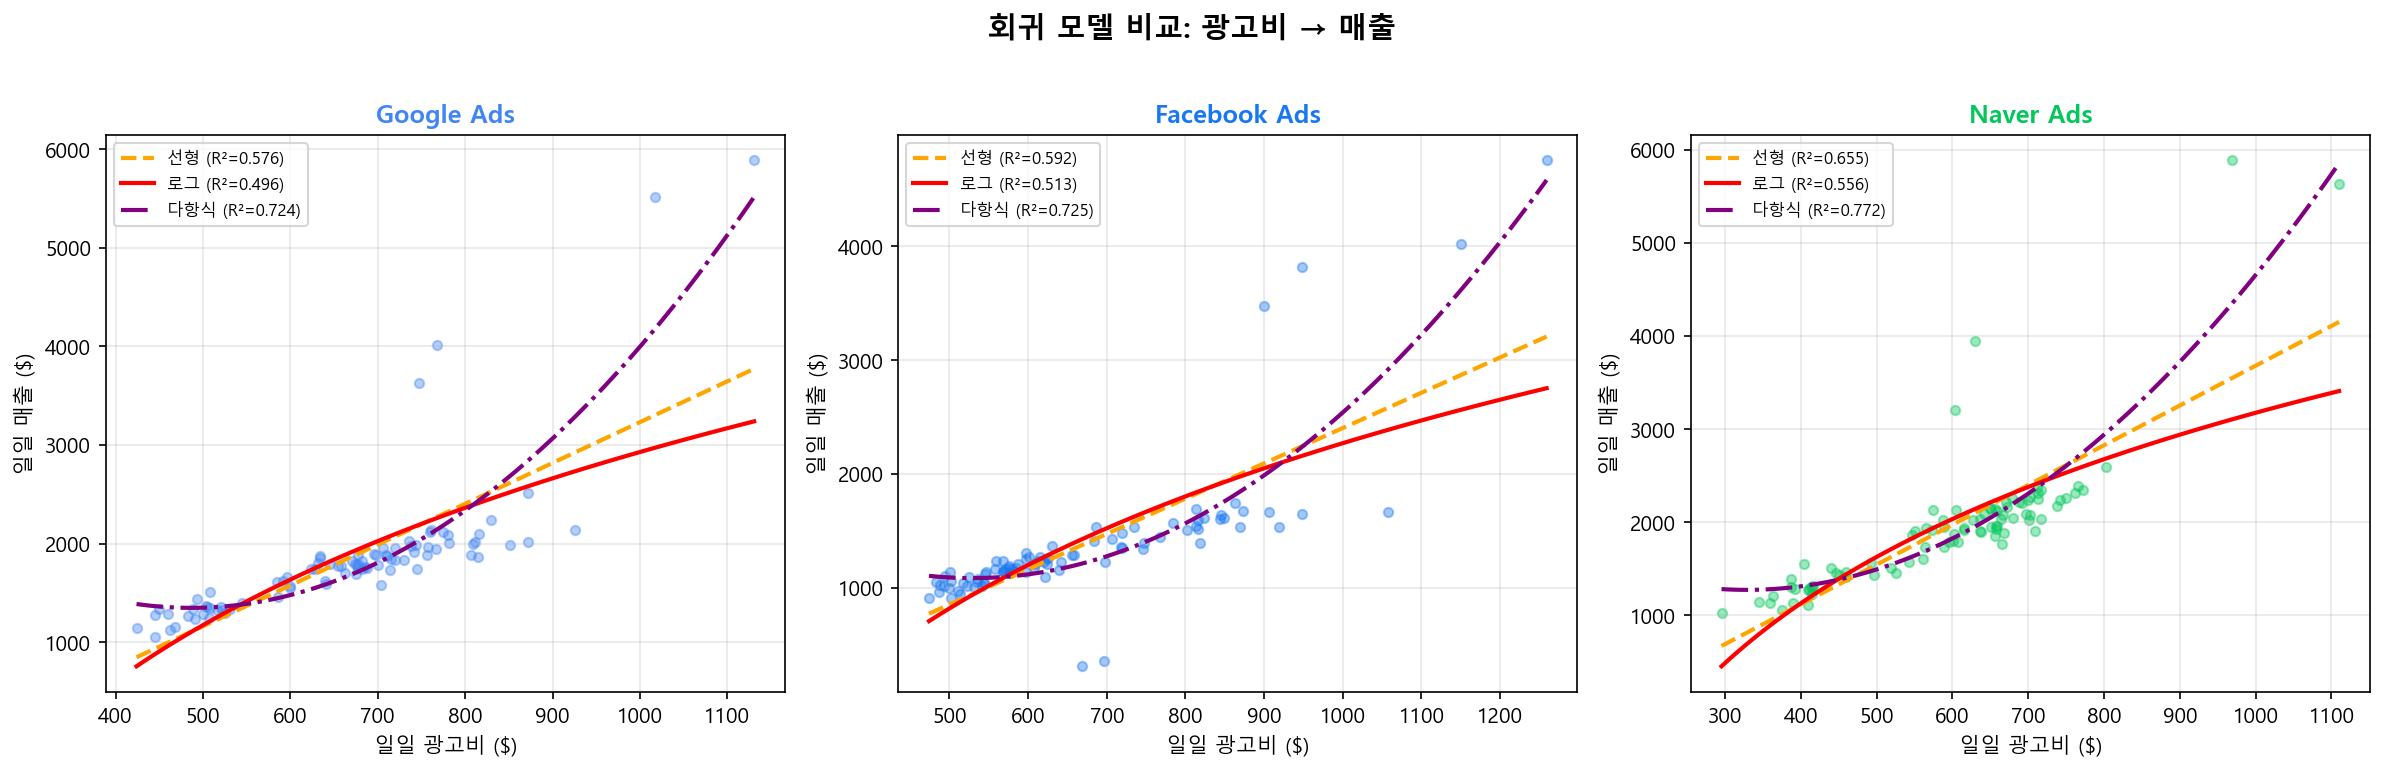


=== 회귀 모델 비교 결과 ===
          채널 선형 R² 로그 R² 다항식 R² 최적 모델
  Google Ads 0.576 0.496  0.724   다항식
Facebook Ads 0.592 0.513  0.725   다항식
   Naver Ads 0.655 0.556  0.772   다항식


In [12]:
# 차트 7: 회귀 모델 비교 (선형 vs 로그 vs 다항식)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 채널별 일별 합산 데이터
daily_channel = df.groupby(['date', 'channel']).agg(
    cost=('cost', 'sum'), revenue=('revenue', 'sum')
).reset_index()

model_results = []

for idx, channel in enumerate(df['channel'].unique()):
    ch = daily_channel[daily_channel['channel'] == channel].copy()
    X = ch['cost'].values.reshape(-1, 1)
    y = ch['revenue'].values
    ax = axes[idx]

    ax.scatter(X, y, alpha=0.4, s=20, color=CHANNEL_COLORS[channel])

    x_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

    # 1) 선형 회귀
    lr = LinearRegression().fit(X, y)
    y_lr = lr.predict(x_plot)
    r2_lr = r2_score(y, lr.predict(X))
    ax.plot(x_plot, y_lr, '--', color='orange', linewidth=2,
            label=f'선형 (R²={r2_lr:.3f})')

    # 2) 로그 회귀
    X_log = np.log(X + 1)
    x_plot_log = np.log(x_plot + 1)
    lr_log = LinearRegression().fit(X_log, y)
    y_log = lr_log.predict(x_plot_log)
    r2_log = r2_score(y, lr_log.predict(X_log))
    ax.plot(x_plot, y_log, '-', color='red', linewidth=2,
            label=f'로그 (R²={r2_log:.3f})')

    # 3) 2차 다항식
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    x_plot_poly = poly.transform(x_plot)
    lr_poly = LinearRegression().fit(X_poly, y)
    y_poly = lr_poly.predict(x_plot_poly)
    r2_poly = r2_score(y, lr_poly.predict(X_poly))
    ax.plot(x_plot, y_poly, '-.', color='purple', linewidth=2,
            label=f'다항식 (R²={r2_poly:.3f})')

    ax.set_title(channel, fontsize=12, fontweight='bold',
                 color=CHANNEL_COLORS[channel])
    ax.set_xlabel('일일 광고비 ($)')
    ax.set_ylabel('일일 매출 ($)')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    model_results.append({
        '채널': channel,
        '선형 R²': f'{r2_lr:.3f}',
        '로그 R²': f'{r2_log:.3f}',
        '다항식 R²': f'{r2_poly:.3f}',
        '최적 모델': ['선형', '로그', '다항식'][np.argmax([r2_lr, r2_log, r2_poly])]
    })

fig.suptitle('회귀 모델 비교: 광고비 → 매출', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_chart(fig, '07_regression_comparison.png')
plt.show()

print('\n=== 회귀 모델 비교 결과 ===')
print(pd.DataFrame(model_results).to_string(index=False))

## 7. 예산 최적화 분석

한계 ROAS 분석을 통해 최적 예산 배분안을 도출합니다.

In [13]:
# 현행 예산 배분 계산
current_budget = df.groupby('channel')['cost'].sum()
current_revenue = df.groupby('channel')['revenue'].sum()
total_budget = current_budget.sum()
current_pct = (current_budget / total_budget * 100).round(1)

print('=== 현행 예산 배분 ===')
for ch in current_budget.index:
    roas = current_revenue[ch] / current_budget[ch]
    print(f'{ch}: ${current_budget[ch]:,.0f} ({current_pct[ch]}%) → ROAS {roas:.2f}')
print(f'합계: ${total_budget:,.0f}')
print(f'전체 ROAS: {current_revenue.sum() / total_budget:.2f}')

# 최적 예산 배분 (ROAS 비중 기반)
channel_roas = current_revenue / current_budget
roas_weight = channel_roas / channel_roas.sum()
optimal_budget = (roas_weight * total_budget).round(0)
optimal_pct = (optimal_budget / total_budget * 100).round(1)

print('\n=== 최적 예산 배분 (ROAS 가중 기반) ===')
for ch in optimal_budget.index:
    change = optimal_budget[ch] - current_budget[ch]
    arrow = '↑' if change > 0 else '↓'
    print(f'{ch}: ${optimal_budget[ch]:,.0f} ({optimal_pct[ch]}%) [{arrow} ${abs(change):,.0f}]')

# 예상 효과
estimated_new_revenue = sum(
    optimal_budget[ch] * (current_revenue[ch] / current_budget[ch])
    for ch in current_budget.index
)
improvement = (estimated_new_revenue / current_revenue.sum() - 1) * 100
print(f'\n예상 매출 변화: ${current_revenue.sum():,.0f} → ${estimated_new_revenue:,.0f} ({improvement:+.1f}%)')

=== 현행 예산 배분 ===
Facebook Ads: $60,044 (34.6%) → ROAS 2.05
Google Ads: $59,818 (34.5%) → ROAS 2.77
Naver Ads: $53,607 (30.9%) → ROAS 3.28
합계: $173,469
전체 ROAS: 2.68

=== 최적 예산 배분 (ROAS 가중 기반) ===
Facebook Ads: $43,965 (25.3%) [↓ $16,079]
Google Ads: $59,357 (34.2%) [↓ $461]
Naver Ads: $70,147 (40.4%) [↑ $16,540]

예상 매출 변화: $464,945 → $484,849 (+4.3%)


저장: charts\08_budget_optimization.png


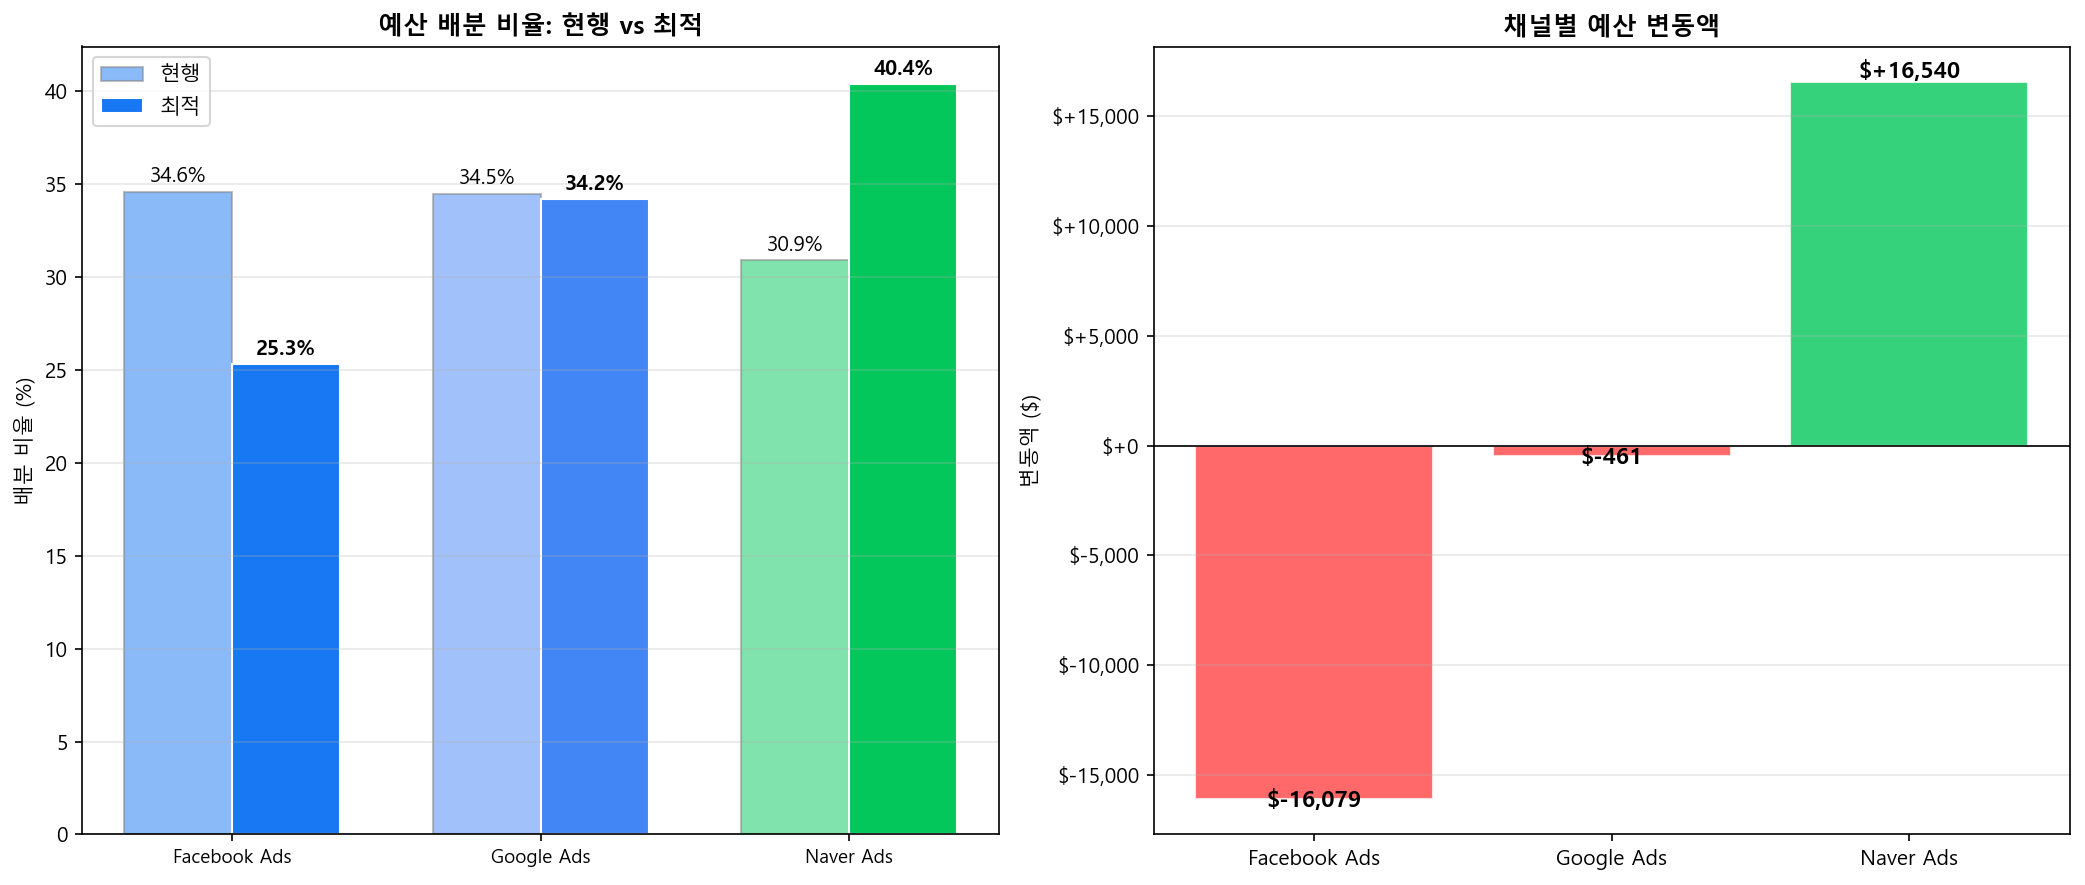

In [14]:
# 차트 8: 현행 vs 최적 예산 배분 (Dual Bar)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

channels = list(current_budget.index)
colors = [CHANNEL_COLORS[c] for c in channels]

# 8a: 비율 비교 (Bar)
ax1 = axes[0]
x = np.arange(len(channels))
width = 0.35

bars1 = ax1.bar(x - width/2, [current_pct[c] for c in channels], width,
                label='현행', color=colors, alpha=0.5, edgecolor='gray')
bars2 = ax1.bar(x + width/2, [optimal_pct[c] for c in channels], width,
                label='최적', color=colors, alpha=1.0, edgecolor='white')

for i, ch in enumerate(channels):
    ax1.text(i - width/2, current_pct[ch] + 0.5, f'{current_pct[ch]}%',
             ha='center', fontsize=10)
    ax1.text(i + width/2, optimal_pct[ch] + 0.5, f'{optimal_pct[ch]}%',
             ha='center', fontsize=10, fontweight='bold')

ax1.set_title('예산 배분 비율: 현행 vs 최적', fontsize=12, fontweight='bold')
ax1.set_ylabel('배분 비율 (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(channels, fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 8b: 변화량 (Waterfall)
ax2 = axes[1]
changes = [optimal_budget[c] - current_budget[c] for c in channels]
bar_colors = ['#03C75A' if c > 0 else '#FF4444' for c in changes]

ax2.bar(channels, changes, color=bar_colors, alpha=0.8, edgecolor='white')
for i, (ch, change) in enumerate(zip(channels, changes)):
    y_pos = change + (200 if change > 0 else -400)
    ax2.text(i, y_pos, f'${change:+,.0f}', ha='center', fontsize=11, fontweight='bold')

ax2.set_title('채널별 예산 변동액', fontsize=12, fontweight='bold')
ax2.set_ylabel('변동액 ($)')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:+,.0f}'))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_chart(fig, '08_budget_optimization.png')
plt.show()

저장: charts\09_marginal_roas.png


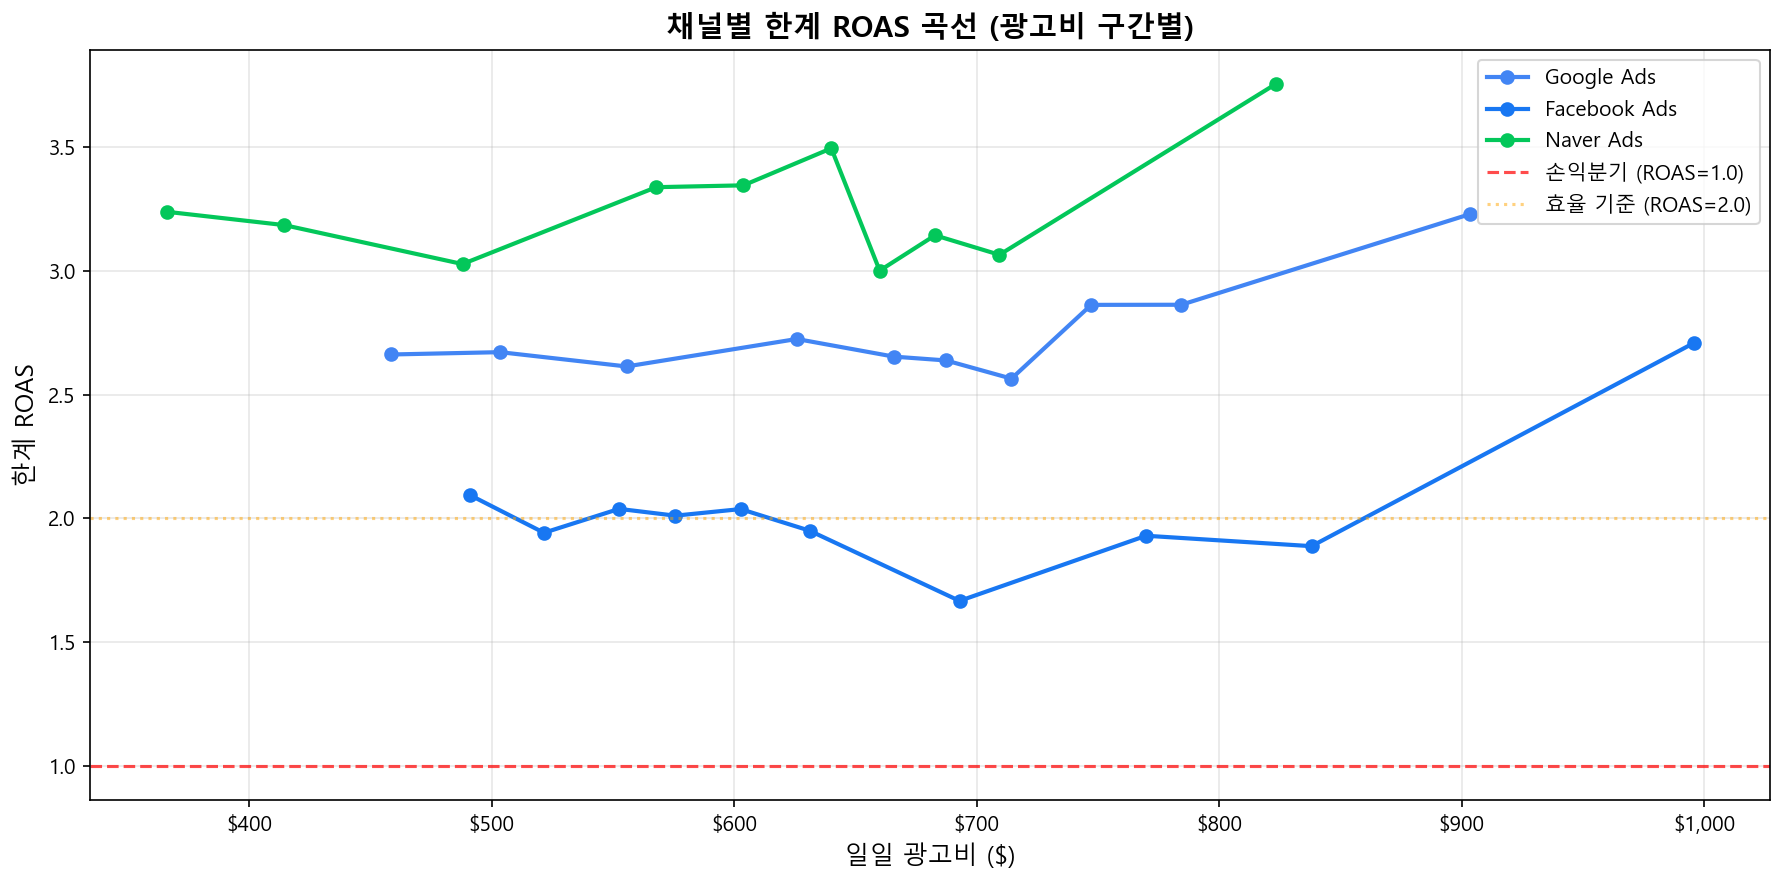

인사이트: 광고비가 증가할수록 한계 ROAS가 감소하는 체감수익 현상이 확인됩니다.
각 채널별 손익분기(ROAS=1) 이하로 내려가기 전의 지출 수준이 최적점입니다.


In [15]:
# 차트 9: 한계 ROAS 곡선
fig, ax = plt.subplots(figsize=(12, 6))

for channel in df['channel'].unique():
    ch_daily = daily_channel[daily_channel['channel'] == channel].copy()
    ch_daily = ch_daily.sort_values('cost')

    # 구간별 한계 ROAS 계산 (10분위)
    ch_daily['cost_bin'] = pd.qcut(ch_daily['cost'], q=10, duplicates='drop')
    marginal = ch_daily.groupby('cost_bin', observed=True).agg(
        avg_cost=('cost', 'mean'),
        avg_revenue=('revenue', 'mean')
    ).reset_index()
    marginal['marginal_roas'] = marginal['avg_revenue'] / marginal['avg_cost']

    ax.plot(marginal['avg_cost'], marginal['marginal_roas'],
            'o-', color=CHANNEL_COLORS[channel], label=channel,
            linewidth=2, markersize=6)

# ROAS = 1 기준선
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5,
           label='손익분기 (ROAS=1.0)')

# ROAS = 2 효율 기준선
ax.axhline(y=2.0, color='orange', linestyle=':', alpha=0.5, linewidth=1.5,
           label='효율 기준 (ROAS=2.0)')

ax.set_xlabel('일일 광고비 ($)', fontsize=12)
ax.set_ylabel('한계 ROAS', fontsize=12)
ax.set_title('채널별 한계 ROAS 곡선 (광고비 구간별)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
save_chart(fig, '09_marginal_roas.png')
plt.show()

print('인사이트: 광고비가 증가할수록 한계 ROAS가 감소하는 체감수익 현상이 확인됩니다.')
print('각 채널별 손익분기(ROAS=1) 이하로 내려가기 전의 지출 수준이 최적점입니다.')

## 8. 이상치 분석

Z-score 기반으로 이상치를 탐지하고, 발생 원인을 추정합니다.

저장: charts\10_outlier_detection.png


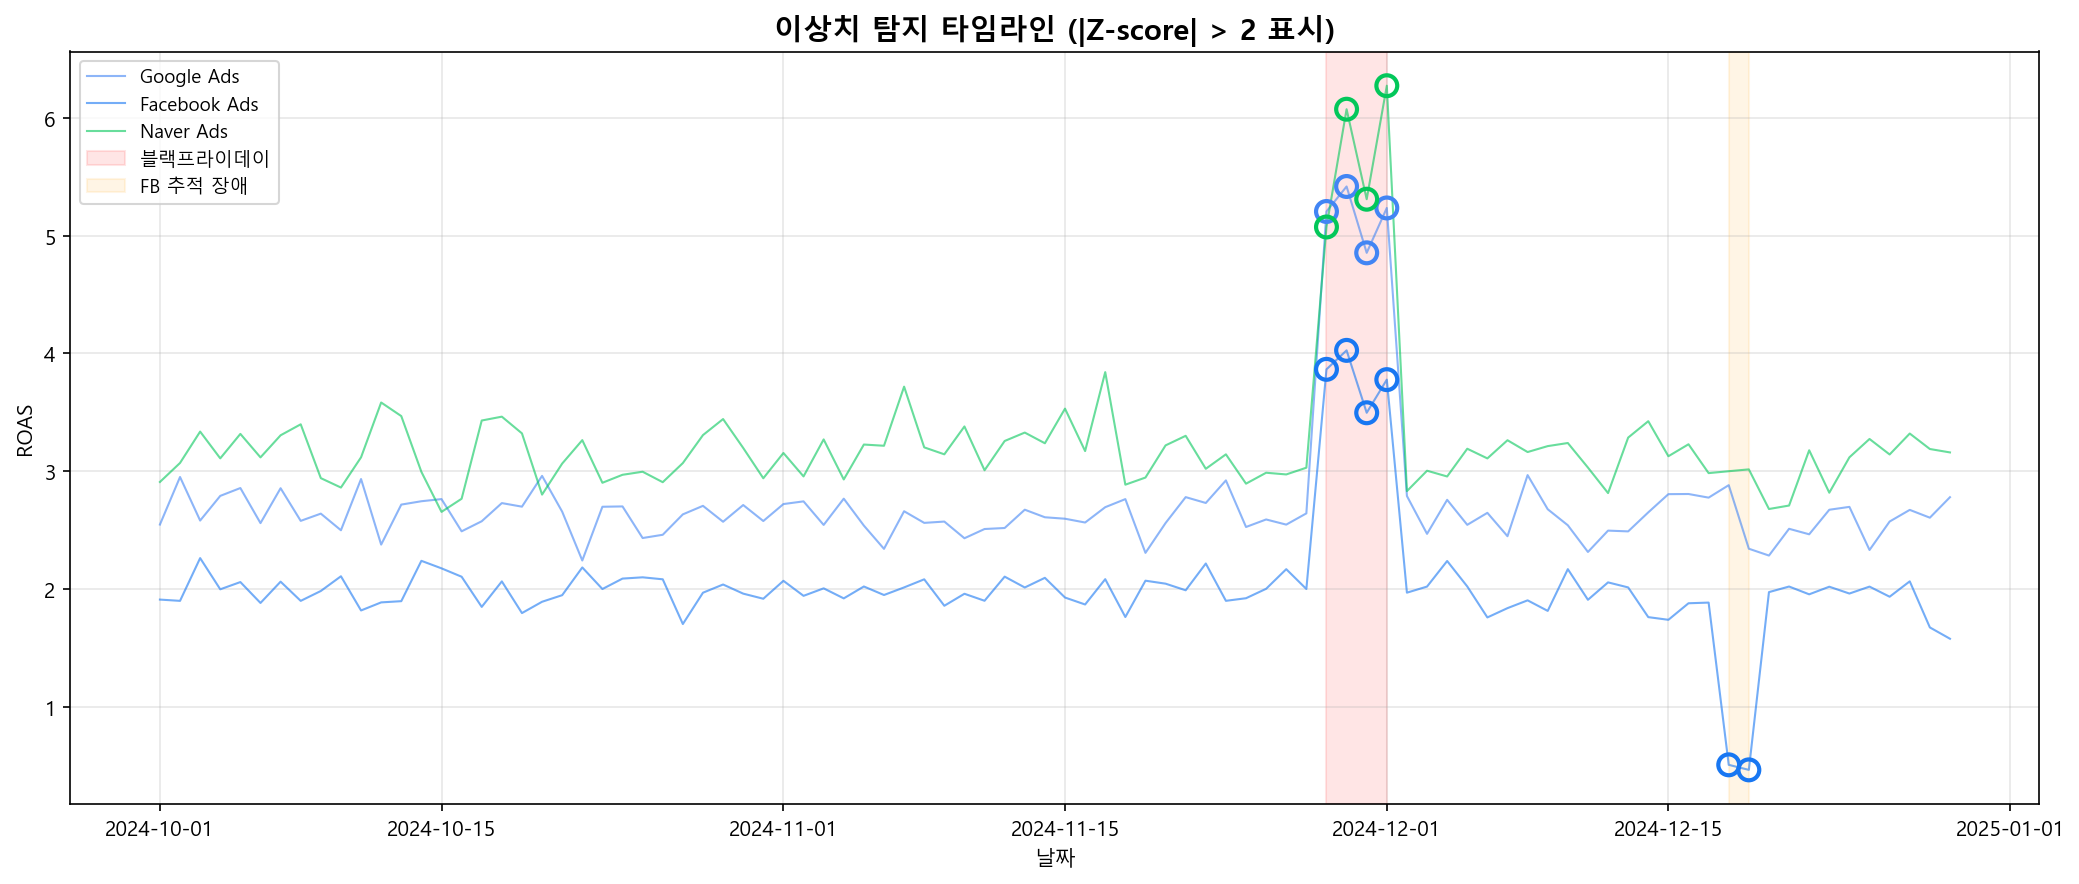


=== 탐지된 이상치: 14건 ===
        날짜           채널 ROAS Z-score 유형
2024-11-28   Google Ads 5.21    4.45 급등
2024-11-29   Google Ads 5.42    4.84 급등
2024-11-30   Google Ads 4.85    3.82 급등
2024-12-01   Google Ads 5.24    4.51 급등
2024-11-28 Facebook Ads 3.86    3.99 급등
2024-11-29 Facebook Ads 4.03    4.34 급등
2024-11-30 Facebook Ads 3.50    3.19 급등
2024-12-01 Facebook Ads 3.78    3.80 급등
2024-12-18 Facebook Ads 0.51   -3.28 급락
2024-12-19 Facebook Ads 0.46   -3.37 급락
2024-11-28    Naver Ads 5.07    3.14 급등
2024-11-29    Naver Ads 6.07    4.86 급등
2024-11-30    Naver Ads 5.31    3.55 급등
2024-12-01    Naver Ads 6.27    5.20 급등


In [16]:
# 차트 10: 이상치 탐지 타임라인
fig, ax = plt.subplots(figsize=(14, 6))

all_outliers = []

for channel in df['channel'].unique():
    ch_daily = df[df['channel'] == channel].groupby('date').agg(
        cost=('cost', 'sum'), revenue=('revenue', 'sum')
    ).reset_index()
    ch_daily['roas'] = ch_daily['revenue'] / ch_daily['cost']

    # Z-score 계산
    mean_roas = ch_daily['roas'].mean()
    std_roas = ch_daily['roas'].std()
    ch_daily['z_score'] = (ch_daily['roas'] - mean_roas) / std_roas

    # 정상 데이터 라인
    ax.plot(ch_daily['date'], ch_daily['roas'],
            color=CHANNEL_COLORS[channel], alpha=0.6, linewidth=1,
            label=channel)

    # 이상치 마킹 (|Z| > 2)
    outliers = ch_daily[ch_daily['z_score'].abs() > 2]
    if len(outliers) > 0:
        ax.scatter(outliers['date'], outliers['roas'],
                   s=100, edgecolors=CHANNEL_COLORS[channel],
                   facecolors='none', linewidth=2, zorder=5)
        for _, row in outliers.iterrows():
            all_outliers.append({
                '날짜': row['date'].strftime('%Y-%m-%d'),
                '채널': channel,
                'ROAS': f"{row['roas']:.2f}",
                'Z-score': f"{row['z_score']:.2f}",
                '유형': '급등' if row['z_score'] > 0 else '급락'
            })

# 이벤트 영역 표시
ax.axvspan(pd.Timestamp('2024-11-28'), pd.Timestamp('2024-12-01'),
           alpha=0.1, color='red', label='블랙프라이데이')
ax.axvspan(pd.Timestamp('2024-12-18'), pd.Timestamp('2024-12-19'),
           alpha=0.1, color='orange', label='FB 추적 장애')

ax.set_xlabel('날짜')
ax.set_ylabel('ROAS')
ax.set_title('이상치 탐지 타임라인 (|Z-score| > 2 표시)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
save_chart(fig, '10_outlier_detection.png')
plt.show()

# 이상치 목록
if all_outliers:
    print(f'\n=== 탐지된 이상치: {len(all_outliers)}건 ===')
    outlier_df = pd.DataFrame(all_outliers)
    print(outlier_df.to_string(index=False))
else:
    print('탐지된 이상치 없음')

## 9. 핵심 인사이트 및 실행 제안

분석 결과를 바탕으로 비즈니스 의사결정에 활용 가능한 인사이트를 정리합니다.

In [17]:
# === 핵심 발견 5가지 ===
print('=' * 70)
print('핵심 인사이트 요약')
print('=' * 70)

insights = [
    {
        '번호': 1,
        '발견': '네이버 광고가 가장 높은 ROAS (3.28) 달성',
        '근거': 'ANOVA 검정 결과 채널 간 ROAS 차이 통계적으로 유의 (p<0.001)',
        '제안': '네이버 광고 예산을 현행 대비 증액하고, 특히 Brand 캠페인 강화'
    },
    {
        '번호': 2,
        '발견': 'Facebook Ads는 주말 성과가 주중 대비 현저히 높음',
        '근거': 't-test 결과 주중/주말 ROAS 차이 유의 (p<0.05)',
        '제안': 'Facebook 예산을 주말에 집중 배분 (주중 감축, 주말 증액)'
    },
    {
        '번호': 3,
        '발견': '전 채널에서 광고비 증가 시 한계 ROAS 감소 (체감수익)',
        '근거': '로그 회귀 모델이 선형보다 적합 (높은 R²)',
        '제안': '단일 채널 집중보다 다채널 분산 투자가 총 ROAS 개선에 유리'
    },
    {
        '번호': 4,
        '발견': 'Brand 캠페인이 전 채널에서 최고 ROAS 달성',
        '근거': '캠페인 성과 매트릭스에서 Brand > Retargeting > Generic/Interest',
        '제안': 'Brand 키워드 방어 예산 우선 확보, Generic 캠페인은 타겟팅 정교화'
    },
    {
        '번호': 5,
        '발견': 'Facebook 추적 장애(12/18-19)로 전환 데이터 80% 누락',
        '근거': 'Z-score 이상치 탐지에서 해당 기간 ROAS 급락 확인',
        '제안': 'Facebook CAPI(서버사이드 추적) 도입으로 추적 안정성 확보'
    }
]

for item in insights:
    print(f"\n[인사이트 {item['번호']}] {item['발견']}")
    print(f"  근거: {item['근거']}")
    print(f"  제안: {item['제안']}")

print('\n' + '=' * 70)

핵심 인사이트 요약

[인사이트 1] 네이버 광고가 가장 높은 ROAS (3.28) 달성
  근거: ANOVA 검정 결과 채널 간 ROAS 차이 통계적으로 유의 (p<0.001)
  제안: 네이버 광고 예산을 현행 대비 증액하고, 특히 Brand 캠페인 강화

[인사이트 2] Facebook Ads는 주말 성과가 주중 대비 현저히 높음
  근거: t-test 결과 주중/주말 ROAS 차이 유의 (p<0.05)
  제안: Facebook 예산을 주말에 집중 배분 (주중 감축, 주말 증액)

[인사이트 3] 전 채널에서 광고비 증가 시 한계 ROAS 감소 (체감수익)
  근거: 로그 회귀 모델이 선형보다 적합 (높은 R²)
  제안: 단일 채널 집중보다 다채널 분산 투자가 총 ROAS 개선에 유리

[인사이트 4] Brand 캠페인이 전 채널에서 최고 ROAS 달성
  근거: 캠페인 성과 매트릭스에서 Brand > Retargeting > Generic/Interest
  제안: Brand 키워드 방어 예산 우선 확보, Generic 캠페인은 타겟팅 정교화

[인사이트 5] Facebook 추적 장애(12/18-19)로 전환 데이터 80% 누락
  근거: Z-score 이상치 탐지에서 해당 기간 ROAS 급락 확인
  제안: Facebook CAPI(서버사이드 추적) 도입으로 추적 안정성 확보



In [18]:
# === 실행 제안 테이블 ===
print('\n=== 실행 제안 (Action Items) ===\n')

actions = pd.DataFrame([
    {'우선순위': '🔴 높음', '항목': '네이버 Brand 캠페인 예산 30% 증액',
     '예상 효과': 'ROAS 3.5+ 구간 매출 확대', '기한': '즉시'},
    {'우선순위': '🔴 높음', '항목': 'Facebook 주말 집중 예산 편성',
     '예상 효과': 'FB ROAS 15-20% 개선', '기한': '1주 내'},
    {'우선순위': '🟡 중간', '항목': 'Facebook CAPI 서버사이드 추적 도입',
     '예상 효과': '추적 누락 방지, 데이터 정확성 향상', '기한': '2주 내'},
    {'우선순위': '🟡 중간', '항목': 'Google Generic 캠페인 타겟팅 정교화',
     '예상 효과': 'ROAS 2.2 → 2.5 목표', '기한': '2주 내'},
    {'우선순위': '🟢 낮음', '항목': '채널별 체감수익 기반 예산 상한선 설정',
     '예상 효과': '예산 낭비 방지', '기한': '1개월 내'},
    {'우선순위': '🟢 낮음', '항목': '블랙프라이데이 대비 사전 예산 계획 수립',
     '예상 효과': '시즌 매출 극대화', '기한': '다음 Q3'},
])

print(actions.to_string(index=False))


=== 실행 제안 (Action Items) ===

우선순위                         항목                예상 효과    기한
🔴 높음    네이버 Brand 캠페인 예산 30% 증액   ROAS 3.5+ 구간 매출 확대    즉시
🔴 높음       Facebook 주말 집중 예산 편성    FB ROAS 15-20% 개선  1주 내
🟡 중간  Facebook CAPI 서버사이드 추적 도입 추적 누락 방지, 데이터 정확성 향상  2주 내
🟡 중간 Google Generic 캠페인 타겟팅 정교화    ROAS 2.2 → 2.5 목표  2주 내
🟢 낮음      채널별 체감수익 기반 예산 상한선 설정             예산 낭비 방지 1개월 내
🟢 낮음     블랙프라이데이 대비 사전 예산 계획 수립            시즌 매출 극대화 다음 Q3


In [19]:
# === 최종 요약 ===
total_cost = df['cost'].sum()
total_revenue = df['revenue'].sum()
total_roas = total_revenue / total_cost
total_conversions = df['conversions'].sum()

print('=' * 70)
print('분석 요약 대시보드')
print('=' * 70)
print(f'분석 기간: 2024-10-01 ~ 2024-12-29 (90일)')
print(f'총 광고비: ${total_cost:,.0f}')
print(f'총 매출: ${total_revenue:,.0f}')
print(f'전체 ROAS: {total_roas:.2f}')
print(f'총 전환수: {total_conversions:,}')
print(f'평균 CPC: ${df["cpc"].mean():.2f}')
print(f'평균 CTR: {df["ctr"].mean()*100:.1f}%')
print(f'평균 CVR: {df["cvr"].mean()*100:.1f}%')
print('=' * 70)
print(f'\n차트 {len(os.listdir(CHARTS_DIR))}개 저장 완료 → {CHARTS_DIR}/')
print('분석 완료!')

분석 요약 대시보드
분석 기간: 2024-10-01 ~ 2024-12-29 (90일)
총 광고비: $173,469
총 매출: $464,945
전체 ROAS: 2.68
총 전환수: 31,501
평균 CPC: $0.25
평균 CTR: 5.3%
평균 CVR: 4.3%

차트 10개 저장 완료 → charts/
분석 완료!
